## Red U-Net para la segmentación del iris

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import skimage.io as io
import skimage.transform as trans
import shutil

from skimage import data

In [4]:
from keras.models import load_model

model = load_model('Iris_unet_d5.h5')
model.summary()

Using TensorFlow backend.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 320, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 160, 160, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [5]:
def create_segmented_dir(path_dataset, samples):
    '''
    Crea la mimsma estructura con la que cuenta el dataset de CASIA en la que se guardará 
    las imágenes segmentadas.
    '''
    # creamos carpeta en la que guardaremos las imágenes
    os.mkdir(path_dataset)
    for i in range(1, samples+1): # 108 sujetos
        sample = path_dataset + os.sep + "%.3d" % i
        os.mkdir(sample)
        for j in range(1,3): # 2 sesiones
            session = sample + os.sep + str(j)
            os.mkdir(session)
    print("-> Estructura de directorios creados satisfactoriamente.")
    

def copy_all_samples(path_samples, destination_directory):
    '''
    Copia todas las muestras del dataset de CASIA a un único directorio.
    '''
    os.mkdir(destination_directory)
        
    for root, dirs, files in os.walk(path_samples):
        for file in files:
            path_file = os.path.join(root,file)
            shutil.copy2(path_file,destination_directory)   
    print("-> Muestras copiadas satisfactoriamente.")

In [6]:
# ejecutar una única vez
# create_segmented_dir('CASIA-IrisV1-Segmented', 108)
# copy_all_samples('CASIA-IrisV1', 'dataset')

In [8]:
def testGenerator(directory,num_image,target_size = (320,320),flag_multi_class = False):
    '''
    Genera las muestras que se le pasarán al método predecir de la red preentrenada.
    
    Parámetros:
    directory -- directorio dónde se encuentran las muestras a generar
    num_image -- número máximo de imágenes que queremos generar
    target_size -- shape de de la muestra
    flag_multi_class -- (de momento mantener pero no nos es útil)
    '''
    i = 0
    for root, dirs, files in os.walk(directory):
        if files: # si es directorio hoja
            for file in files:
                if i == num_image:
                    break # sólo queremos x imágenes para probar
                path_file = os.path.join(root,file)
                img = cv2.imread(path_file,0)
                img = img / 255
                img = trans.resize(img,target_size)
                img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
                img = np.reshape(img,(1,)+img.shape)
                i += 1
                yield img

def get_samples_names(directory):
    '''
    Devuelve los nombres de las muestras(los que se encuentran en los directorios hoja)
    
    Parámetros:
    directory -- directorio de cuyos subdirectorios hoja se quiere el nombre 
    '''
    names = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            names.append(str(file))
            
    return names

def saveResult(save_path, name_path,npyfile,flag_multi_class = False):
    '''
    Guarda los imágenes segmentadas resultado de la red preentrenada
    
    Parámetros:
    save_path -- ruta en la que se guardarán las muestras segmentadas
    name_path -- ruta en la que se encuentran los nombres de las muestras
    npyfile -- resultado de la red preentrenada
    flag_multi_class -- (de momento mantener pero no nos es útil)
    '''
    dim = (320, 280) # dimensioned de las muestras del dataset
    if not os.path.isdir(save_path):
        os.mkdir(save_path)
        names = get_samples_names(name_path)
    #     for item, name in zip(npyfile, names):
    #         img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
    #         cv2.imwrite(os.path.join(save_path,name),img) # con cv2 da problemas
        for i,item in enumerate(npyfile):
            img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
            img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
            io.imsave(os.path.join(save_path,names[i]),img)

In [9]:
testGene = testGenerator("CASIA-IrisV1", 10) #len(os.listdir('dataset')))
results = model.predict(testGene,15,verbose=1)
# saveResult("CASIA-IrisV1-Segmented","CASIA-IrisV1",results)

10/10 [==============================] - 11s 1s/step


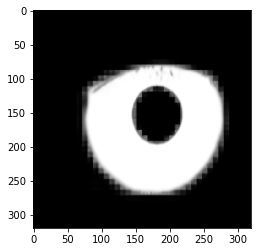

In [10]:
img = results[0][:,:,0]
plt.imshow(img, cmap='gray');

La segmentación se ha realizado correctamente, los únicos inconvenientes que aparecen puede ser que los bordes límbico y pupilar no aparecen bien definidos(están pixelados), y aparte cómo en el método `testGenerator` se cambió la resolución de la imagen a una cuadrada de 320x320, se aprecia que tanto la pupila como el iris están ovalados.

Sin embargo en el método `saveResult` se corrige el problema de la resolución, ya que volvemos a redimensionar la muestra segmentada para que cuente con las mismas dimensiones que las muestras originales.

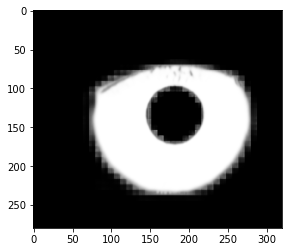

In [11]:
resized = cv2.resize(img, (320, 280), interpolation=cv2.INTER_AREA)
plt.imshow(resized, cmap='gray');

Vamos a superponer la muestra segmentada sobre la muestra completa del ojo para comprobar que ha aislado correctamente el iris.